In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import random
import time
from utils import *

In [2]:
class SpikingNeuron(torch.nn.Module):
    def __init__(self, n_out, sigmoid = False, verbose = False, thresh = 1):
        super(SpikingNeuron, self).__init__()
        self.fc = Dense(n_out, 1, sigmoid = sigmoid)
        self.thresh = thresh
        self.voltage = torch.tensor([0]).float()
        self.n_out = n_out
    
    
    def forward(self, x):
        if(x.shape[0] != self.n_out):
            raise Exception(
                'number of inputs must equal number of connections, {} and {} where given'.format(x.shape[0],self.n_out))
        #update voltage and calculate spikes
        self.voltage += self.fc(x)
        spike = self.voltage >= self.thresh
        self.voltage *= ~spike
        
        return spike, self.voltage

class Net(torch.nn.Module):
    def __init__(self, mod = False):
        super(Net, self).__init__()
        
        #-1
        #  \
        #   3
        #  /
        #-2
        self.spike1 = SpikingNeuron(2)
        self.s1 = torch.tensor([0]).bool()
        
        self.spike2 = SpikingNeuron(2)
        self.s2 = torch.tensor([0]).bool()
        
        self.spike3 = SpikingNeuron(2)
        self.s3 = torch.tensor([0]).bool()
       
    def forward(self, x, training = True):
        x = x.bool()
        
        draw = []
        self.s1, v = self.spike1(torch.stack((x[0].unsqueeze(0),self.s3)))
        draw.append(v)
        
        self.s2, v = self.spike2(torch.stack((x[1].unsqueeze(0),self.s3)))
        draw.append(v)
        
        self.s3, v = self.spike3(torch.stack((self.s1,self.s2)))
        draw.append(v)
        
        #print(self.s1 ,self.s2 ,self.s3 )
        #print(draw)
        #print()
        return torch.stack(draw)

def draw_spikes(x, shape):
    canvas = np.zeros([ max(shape), len(shape)])
    #print(canvas.shape)
    index = 0
    
    for idx, s in enumerate(shape):
        for j in range(s):
            canvas[j][idx] = x[index]

            index += 1
    
    ax.clear()
    ax.imshow(canvas,vmin=-0.1, vmax=1)
    
model = Net(mod = False)


<IPython.core.display.Javascript object>


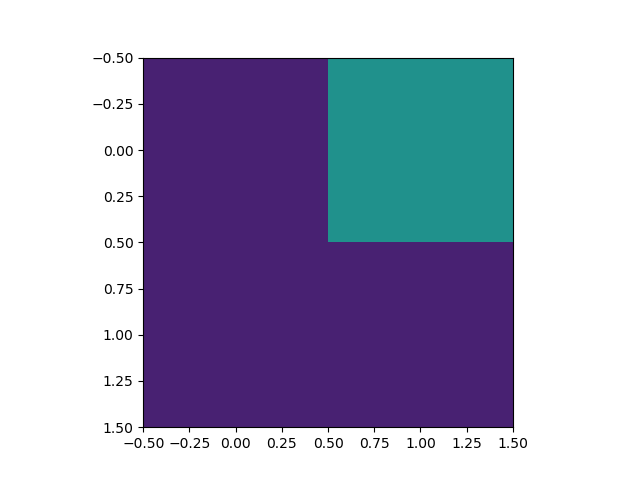

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

epochs = 50
x_fire = np.array(random.sample(range(1,epochs), epochs // 4))
y_fire = []#x_fire + 2
#x_fire = []
for e in range(epochs):
    in_stream = torch.tensor([e in x_fire, e in y_fire], dtype=torch.float)
    #if 1 in in_stream:
    #    print("In signal")
        
    #time.sleep(0.01)
    fig.canvas.set_window_title("Step : {},   {}".format(e,in_stream.data))
    
    s = model(in_stream)
    draw_spikes(s,[2,1])
    fig.canvas.draw()